## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [3]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim

We always check that we are running on a GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ The code will run on NVIDIA GPU (CUDA).")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ The code will run on Apple Silicon GPU (MPS).")
else:
    device = torch.device("cpu")
    print("⚠️ The code will run on CPU. If you’re in Colab, go to Edit → Notebook Settings → Hardware Accelerator → GPU.")


✅ The code will run on Apple Silicon GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [5]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

size = 128

train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),  # random zoom/crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # typical RGB normalization
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 128
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


In [7]:
print("Size of training dataset:", len(trainset))
print("Size of test dataset:", len(testset))
# just modyfing images, not adding original images transformed

# Count hotdog (0) and not hotdog (1) in trainset
train_labels = [label for _, label in trainset]
num_hotdog_train = sum(l == 0 for l in train_labels)
num_not_hotdog_train = sum(l == 1 for l in train_labels)

print(f"Train set - Hotdog: {num_hotdog_train}, Not hotdog: {num_not_hotdog_train}")

# Count hotdog (0) and not hotdog (1) in testset
test_labels = [label for _, label in testset]
num_hotdog_test = sum(l == 0 for l in test_labels)
num_not_hotdog_test = sum(l == 1 for l in test_labels)

print(f"Test set - Hotdog: {num_hotdog_test}, Not hotdog: {num_not_hotdog_test}")

Size of training dataset: 2047
Size of test dataset: 1862
Train set - Hotdog: 1075, Not hotdog: 972
Test set - Hotdog: 895, Not hotdog: 967


In [8]:
# Get one batch from train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Batch size:", images.size(0))

print("Image shape:", images.size())  # (batch_size, channels, height, width)

Batch size: 128
Image shape: torch.Size([128, 3, 128, 128])


Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8382572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.23912

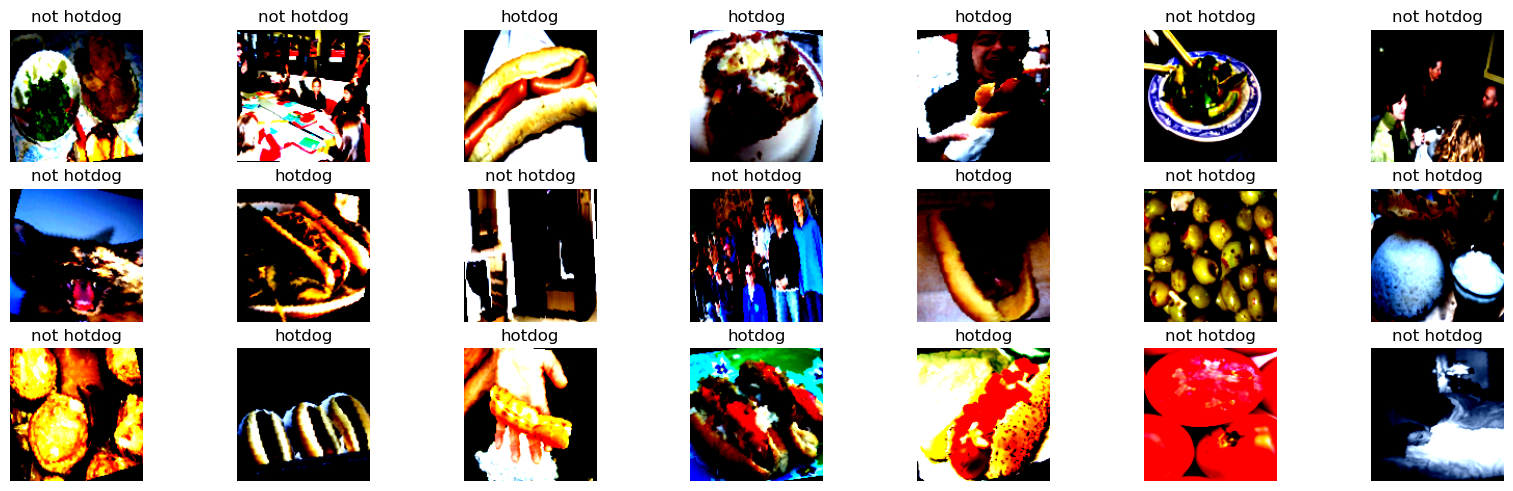

In [9]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Global Average Pooling (GAP):
        # Takes each feature map of size [H, W] and averages it into a single number.
        # This reduces [batch, 512, H, W] → [batch, 512, 1, 1],
        # effectively keeping only the "strength" of each feature channel
        # instead of spatial details. Helps reduce parameters & overfitting.
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


    def convolutional(self, x):
        return self.features(x)


In [11]:
model = Network()
model = model.to(device)

#Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [12]:
# Check device of model
print("Model device:", next(model.parameters()).device)

# Get one batch
data, target = next(iter(train_loader))

# Move to same device + dtype as model
data = data.to(next(model.parameters()).device).float()

print("Input shape:", data.shape, data.dtype, data.device)

# Run through conv layers
print('Shape of the output from the convolutional part:', model.convolutional(data).shape)


Model device: mps:0
Input shape: torch.Size([128, 3, 128, 128]) torch.float32 mps:0
Shape of the output from the convolutional part: torch.Size([128, 512, 4, 4])


As the model predict most likely being an hotodg, this attempt is to penalzie the odel once it does so.

In [13]:
num_epochs = 5

# Define weights once (hotdog = 5x penalty, not-hotdog = 1x)
class_weights = torch.tensor([1.0, 1.0], device=device)

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()
    train_correct = 0
    train_loss = 0.0

    # ---------------- TRAINING ----------------
    for data, target in tqdm(train_loader, total=len(train_loader), leave=False):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        # Weighted cross-entropy
        loss = F.cross_entropy(output, target, weight=class_weights)

        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        train_loss += loss.item() * data.size(0)   # sum over batch
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().item()

    # ---------------- EVALUATION ----------------
    model.eval()
    test_correct = 0
    test_loss = 0.0
    incorrect_indices = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = F.cross_entropy(output, target, weight=class_weights)

            test_loss += loss.item() * data.size(0)
            probs = torch.softmax(output, dim=1)
            predicted = probs.argmax(1)
            test_correct += (target == predicted).sum().item()


            # Save incorrect indices
            incorrect = (predicted != target).nonzero(as_tuple=True)[0]
            start_idx = batch_idx * batch_size
            incorrect_global_indices = (start_idx + incorrect).tolist()
            incorrect_indices.extend(incorrect_global_indices)

    # ---------------- METRICS ----------------
    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)
    train_loss /= len(trainset)
    test_loss /= len(testset)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}% "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.1f}%")


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 0.6619 | Train Acc: 65.6% Test Loss: 0.7187 | Test Acc: 57.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 0.5443 | Train Acc: 73.2% Test Loss: 0.8100 | Test Acc: 54.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 0.4960 | Train Acc: 77.2% Test Loss: 0.6205 | Test Acc: 72.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 0.4690 | Train Acc: 78.3% Test Loss: 0.4856 | Test Acc: 77.3%


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 0.4664 | Train Acc: 79.5% Test Loss: 0.7005 | Test Acc: 71.9%


In [14]:
#torch.save(model, "model_full.pth")

83% of accuracy achived

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.2710083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.0947855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.0

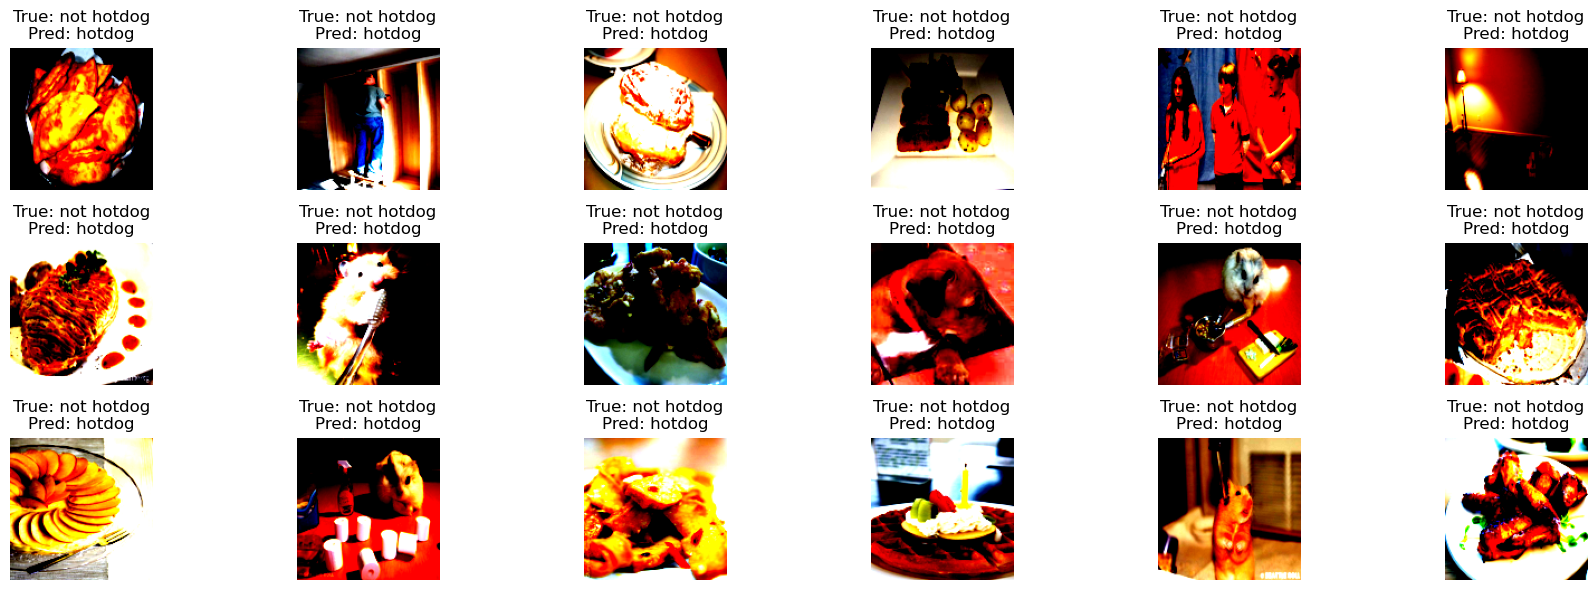

In [15]:
# Show some incorrectly predicted images from the test set
num_to_show = 18  # Number of images to display
plt.figure(figsize=(18, 6))

for idx, img_idx in enumerate(incorrect_indices[:num_to_show]):
    img, true_label = testset[img_idx]

    # Model expects batch, so add batch dimension and move to device
    img_device = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_device).argmax(1).item()

    # Plot needs CPU numpy array, so convert back
    plt.subplot(3, 6, idx + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # keep original CPU img for visualization
    plt.title(f"True: {['hotdog','not hotdog'][true_label]}\nPred: {['hotdog','not hotdog'][pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
# Count predictions for hotdog (0) and not hotdog (1) in the test set
all_preds = []
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)

all_preds = np.array(all_preds)
num_hotdog = np.sum(all_preds == 0)
num_not_hotdog = np.sum(all_preds == 1)
total = len(all_preds)

pct_hotdog = 100 * num_hotdog / total
pct_not_hotdog = 100 * num_not_hotdog / total

print(f"Predicted as hotdog: {num_hotdog} ({pct_hotdog:.2f}%)")
print(f"Predicted as not hotdog: {num_not_hotdog} ({pct_not_hotdog:.2f}%)")

Predicted as hotdog: 630 (33.83%)
Predicted as not hotdog: 1232 (66.17%)


### Saliency Map

In [31]:
def compute_saliency_map(model, image, target_class):

    model.eval()

    # Ensure batch dimension
    if image.ndim == 3:
        image = image.unsqueeze(0)  # (1,C,H,W)

    # Enable gradient tracking on input
    image = image.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(image)

    score = output[0, target_class]

    # Backward pass wrt image
    model.zero_grad()

    # where the actual gradient is computed
    score.backward()

    # Gradient wrt image = saliency
    saliency = image.grad.abs().squeeze()

    return saliency


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


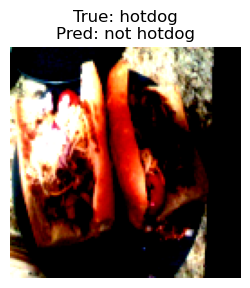

In [43]:
import random

# Pick a random incorrectly predicted image from the test set and display it

if incorrect_indices:
    rand_idx = random.choice(incorrect_indices)
    rand_img, rand_label = testset[rand_idx]

    # Model expects batch dimension and device
    rand_img_device = rand_img.unsqueeze(0).to(device)

    with torch.no_grad():
        rand_pred = model(rand_img_device).argmax(1).item()

    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(rand_img.cpu().numpy(), (1, 2, 0)))
    plt.title(f"True: {['hotdog','not hotdog'][rand_label]}\nPred: {['hotdog','not hotdog'][rand_pred]}")
    plt.axis('off')
    plt.show()
else:
    print("No incorrect predictions found.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


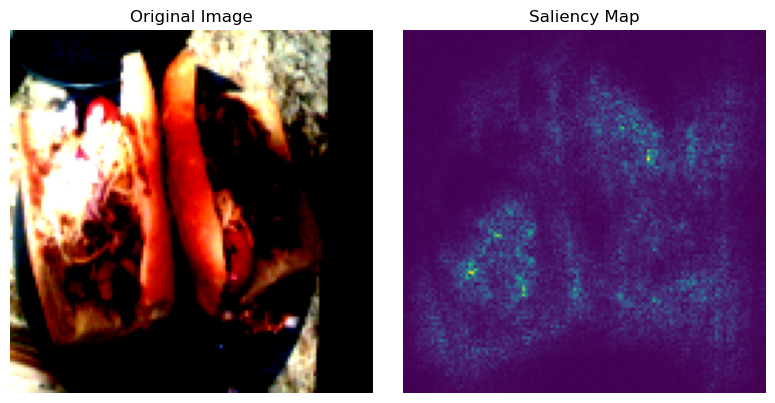

In [44]:
# Compute and display the saliency map for the selected random incorrect image

if incorrect_indices:
    saliency = compute_saliency_map(model, rand_img_device, 0)
    saliency_np = saliency.cpu().numpy().max(axis=0)  # Take max over channels for visualization

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(rand_img.cpu().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_np, cmap='viridis')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No incorrect predictions found.")

Ready-made function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


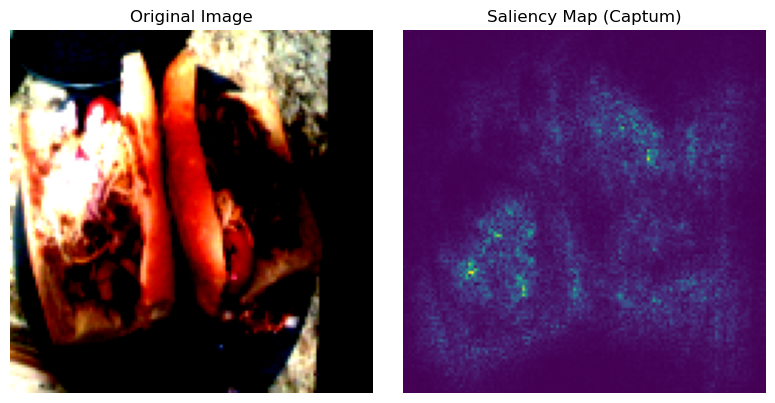

In [45]:
from captum.attr import Saliency

saliency = Saliency(model)
attributions = saliency.attribute(rand_img_device, target=1)

# Convert attributions to numpy and take max over channels for visualization
saliency_map = attributions.abs().detach().cpu().numpy().squeeze()
if saliency_map.ndim == 3:
    saliency_map = saliency_map.max(axis=0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(rand_img.cpu().numpy(), (1, 2, 0)))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map (Captum)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [39]:
raise RuntimeError("Stopping execution here as requested.")

RuntimeError: Stopping execution here as requested.

### Transfer learning ResNet ###

In [ ]:
# ------------------------------
# Transforms (ResNet expects 224x224 + normalization)
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------
# Datasets & DataLoaders
# -----------------------------   -
train_dataset = Hotdog_NotHotdog(train=True, transform=transform, data_path="hotdog_nothotdog")
test_dataset  = Hotdog_NotHotdog(train=False, transform=transform, data_path="hotdog_nothotdog")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ------------------------------
# Load Pretrained ResNet18
# ------------------------------
model = torchvision.models.resnet18(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace classifier for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# ------------------------------
# Training Setup
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.to(device)

# ------------------------------
# Training Loop
# ------------------------------
num_epochs = 5

for epoch in range(num_epochs):
    # ------------------ TRAIN ------------------
    model.train()
    train_correct, total = 0, 0
    
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()
        total += target.size(0)

    train_acc = 100 * train_correct / total

    # ------------------ TEST ------------------
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            test_correct += (predicted == target).sum().item()
            test_total += target.size(0)

    test_acc = 100 * test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


# ------------------------------
# Save the Model
# ------------------------------
torch.save(model.state_dict(), "resnet18_hotdog.pth")
print("Model saved to resnet18_hotdog.pth ✅")

/opt/anaconda3/envs/intro_DL_CV/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/intro_DL_CV/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/5] Train Acc: 83.00% | Test Acc: 92.11%


Epoch 2/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/5] Train Acc: 91.89% | Test Acc: 92.37%


Epoch 3/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/5] Train Acc: 93.06% | Test Acc: 91.78%


Epoch 4/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/5] Train Acc: 93.40% | Test Acc: 92.43%


Epoch 5/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/5] Train Acc: 92.38% | Test Acc: 91.41%
Model saved to resnet18_hotdog.pth ✅
